In [6]:
import os
import sys

import json
import pickle

import scipy
import seaborn as sns

import numpy as np
import pandas as pd
from dtw import dtw
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
import dcor

In [7]:
data = pd.read_csv("../data/data.csv")
data.rename(columns = {0:'Date'}, inplace = False)
cols = data.columns.tolist()
cols = cols[-1:]+cols[1:-1]
data  = data[cols]
data["Date"] = pd.to_datetime(data["Date"])
data = data.set_index("Date")
data.index = data.index - pd.Timedelta(days = 1)

meta = pd.read_csv("../data/meta.csv")

In [8]:
number_of_nans = data.isna().sum()
usable = number_of_nans[number_of_nans < 1000].index
data_nans_removed = data[usable].interpolate()
data_nans_removed

,1515,1516,1518,1521,1719,1722,1723,2040,2046,2048,...,1527,1729,1726,2541,1530,1734,2741,2545,210888,210900
Date,,,,,,,,,,,,,,,,,,,,,
1950-12-31,-114.0,-8.0,-88.0,130.0,238.5,204.5,194.5,305.0,408,376.0,...,-14,125.5,125.0,120.0,50.0,73.0,217.0,18.0,438.0,414.0
1951-01-01,-122.0,-22.0,-102.0,110.0,200.5,182.5,160.5,260.0,376,330.0,...,-16,117.5,125.0,86.0,28.0,81.0,146.0,20.0,417.0,400.0
1951-01-02,-129.0,-32.0,-119.0,80.0,164.5,164.5,114.5,220.0,334,291.0,...,-18,116.5,121.0,50.0,30.0,73.0,108.0,16.0,390.0,388.0
1951-01-03,-134.0,-36.0,-124.0,60.0,132.5,128.5,88.5,182.0,286,242.0,...,-20,108.5,121.0,24.0,25.0,67.0,82.0,16.0,360.0,370.0
1951-01-04,-153.0,-52.0,-135.0,50.0,110.5,108.5,80.5,147.0,239,195.0,...,-22,106.5,119.0,0.0,32.0,63.0,60.0,6.0,322.0,349.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,-27.0,75.0,-69.0,309.0,478.0,138.0,204.0,451.0,-78,-153.0,...,148,46.0,54.0,48.0,155.0,52.0,74.0,-18.0,272.0,325.0
2020-12-27,-94.0,21.0,-50.0,333.0,488.0,206.0,252.0,464.0,20,-101.0,...,162,45.0,52.0,128.0,154.0,42.0,82.0,-17.0,272.0,325.0
2020-12-28,-137.0,-20.0,-92.0,311.0,481.0,201.0,250.0,461.0,120,-2.0,...,154,46.0,63.0,116.0,145.0,40.0,83.0,-22.0,272.0,325.0


In [66]:
def pearson(dx, dy):
    return scipy.stats.pearsonr(dx,dy)

def spearman(dx,dy):
    return scipy.stats.spearmanr(dx,dy)

def distance_correlation(dx,dy):
    return dcor.distance_correlation(dx, dy),0

def timewarping(dx,dy):
    distance, cost_matrix, acc_cost, path = dtw(np.array(dx).reshape(-1,1),np.array(dy).reshape(-1,1), dist = scipy.spatial.distance.euclidean)
    return distance



def corr(df,starting_point,interval,method,l,pv,p1):
    period2 = df[(df.index >= starting_point - interval) & (df.index <= starting_point + interval)]

    for col in df.columns.tolist():
        cor, p_value = method(p1['2275'],period2[col])
        l.append(cor)
        pv.append(p_value)



def calculate_correlations(df,starting_point,interval,method):

    day = pd.Timedelta(1,'d')
    sp = starting_point
    l = []
    pv = []

    period1 = df[(df.index >= starting_point - interval) & (df.index <= starting_point + interval)]
    for i in np.linspace(0,5,5):
        starting_point = starting_point + day
        corr(df,starting_point,interval,method,l,pv,period1)
    starting_point =  sp + day
    for i in np.linspace(0,50,50):
        starting_point = starting_point - day
        corr(df,starting_point,interval,method,l,pv,period1)

    cm = np.transpose(np.reshape(np.array(l), (-1, len(df.columns))))
    pv = np.transpose(np.reshape(np.array(pv), (-1, len(df.columns))))

    return cm, pv


correlation_matrix, p_values = calculate_correlations(data_nans_removed,pd.Timestamp('2006-01-01'),pd.Timedelta(52,'w'),distance_correlation)

/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


In [39]:
from statsmodels.tsa.stattools import grangercausalitytests

def causality_test(df, lag,l,pv):

    for col in df.columns.tolist():
        vals = grangercausalitytests(data_nans_removed[['2275',col]], maxlag = [lag],verbose = 0)
        l.append(vals[lag][0]['ssr_ftest'][0])
        pv.append(vals[lag][0]['ssr_ftest'][1])


causalities = []
p_values = []
for i in np.linspace(1,10,10):
    causality_test(data_nans_removed,i,causalities,p_values)

causalitiy_matrix = np.transpose(np.reshape(np.array(causalities), (-1, len(data_nans_removed.columns))))


/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1

In [44]:
max_corr = pd.Series((cr.idxmax() - 5),name="maximum_correlation")
max_corr.index = max_corr.index.astype(int)

In [45]:
meta = pd.read_csv("../data/meta.csv")
meta = meta.set_index("reg_number")

meta_nans_removed = meta.loc[list(map(int,cr.columns.tolist()))]
meta_nans_removed = pd.concat([meta_nans_removed, max_corr], axis=1)


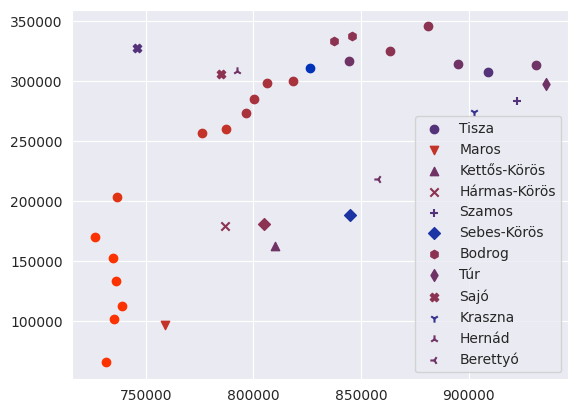

In [67]:
marker_dict = {
    'Tisza': 'o',
    'Maros': 'v',
    'Kettős-Körös': '^',
    'Hármas-Körös': 'x',
    'Szamos': '+',
    'Sebes-Körös' : 'D',
    'Bodrog' : 'h',
    'Túr' : 'd',
    'Sajó' : 'X',
    'Kraszna' : '1',
    'Hernád' : '2',
    'Berettyó': '3'}

def rgb(val):
    return [[0.99 - val * 0.11,0.2, 0 + val * 0.08]]

rivers = []
actors = []

for index,row in meta_nans_removed.iterrows():
    a = plt.scatter(row['EOVx'],row['EOVy'],c=rgb(row['maximum_correlation']),marker=marker_dict[row['river']])
    if row['river'] not in rivers:
        rivers.append(row['river'])
        actors.append(a)
plt.legend(actors,meta_nans_removed.river.unique())
plt.show()

In [58]:
rgb(9)

[[0.0, 0.2, 0.26]]

In [56]:
vals = grangercausalitytests(data_nans_removed[['2275','1515']], maxlag = 8)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9456.9714, p=0.0000  , df_denom=25564, df_num=1
ssr based chi2 test:   chi2=9458.0812, p=0.0000  , df=1
likelihood ratio test: chi2=8047.5188, p=0.0000  , df=1
parameter F test:         F=9456.9714, p=0.0000  , df_denom=25564, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2099.8142, p=0.0000  , df_denom=25561, df_num=2
ssr based chi2 test:   chi2=4200.4499, p=0.0000  , df=2
likelihood ratio test: chi2=3889.0635, p=0.0000  , df=2
parameter F test:         F=2099.8142, p=0.0000  , df_denom=25561, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1495.1316, p=0.0000  , df_denom=25558, df_num=3
ssr based chi2 test:   chi2=4486.6234, p=0.0000  , df=3
likelihood ratio test: chi2=4133.6676, p=0.0000  , df=3
parameter F test:         F=1495.1316, p=0.0000  , df_denom=25558, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:       